#Install python packages

##Install packages

In [1]:
# ## install required packages
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install gym==0.21.0 yfinance pandas ta
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
# !pip install pandas_market_calendars

## Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

## Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

#Download Data

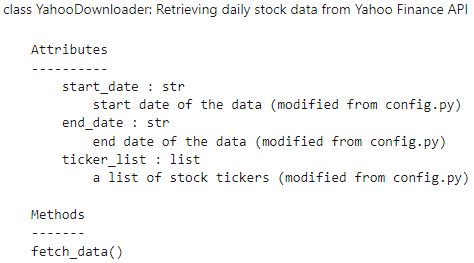

In [5]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [6]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-03-01'

In [7]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (112073, 8)


In [8]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [9]:
df.shape

(112073, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.424606,6.439316,6.375674,6.407195,493729600,AAPL,0
1,2010-01-04,39.913246,40.016969,39.111109,39.159514,5277400,AMGN,0
2,2010-01-04,32.637970,32.781539,32.215241,32.550236,6894300,AXP,0
3,2010-01-04,43.777554,43.941193,42.702205,43.419105,6186700,BA,0
4,2010-01-04,39.403469,39.834181,38.703561,38.797781,7325600,CAT,0


#Preprocess Data

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3812, 8)
Successfully added vix
Successfully added turbulence index


In [12]:
processed.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,6.424606,6.439316,6.375674,6.407195,493729600,AAPL,0,0.0,6.445868,6.414452,100.0,66.666667,100.0,6.424606,6.424606,20.040001,0.0
1,2010-01-04,39.913246,40.016969,39.111109,39.159514,5277400,AMGN,0,0.0,6.445868,6.414452,100.0,66.666667,100.0,39.913246,39.913246,20.040001,0.0
2,2010-01-04,32.637970,32.781539,32.215241,32.550236,6894300,AXP,0,0.0,6.445868,6.414452,100.0,66.666667,100.0,32.637970,32.637970,20.040001,0.0
3,2010-01-04,43.777554,43.941193,42.702205,43.419105,6186700,BA,0,0.0,6.445868,6.414452,100.0,66.666667,100.0,43.777554,43.777554,20.040001,0.0
4,2010-01-04,39.403469,39.834181,38.703561,38.797781,7325600,CAT,0,0.0,6.445868,6.414452,100.0,66.666667,100.0,39.403469,39.403469,20.040001,0.0


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.424606,6.439316,6.375674,6.407195,493729600.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,6.424606,6.424606,20.040001,0.0
1,2010-01-04,AMGN,39.913246,40.016969,39.111109,39.159514,5277400.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,39.913246,39.913246,20.040001,0.0
2,2010-01-04,AXP,32.637970,32.781539,32.215241,32.550236,6894300.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,32.637970,32.637970,20.040001,0.0
3,2010-01-04,BA,43.777554,43.941193,42.702205,43.419105,6186700.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,43.777554,43.777554,20.040001,0.0
4,2010-01-04,CAT,39.403469,39.834181,38.703561,38.797781,7325600.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,39.403469,39.403469,20.040001,0.0
5,2010-01-04,CRM,18.542521,18.718478,18.386389,18.490477,7906000.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,18.542521,18.542521,20.040001,0.0
6,2010-01-04,CSCO,16.158163,16.256329,15.713143,15.778587,59853700.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,16.158163,16.158163,20.040001,0.0
7,2010-01-04,CVX,42.134518,42.209129,41.654872,41.676186,10173800.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,42.134518,42.134518,20.040001,0.0
8,2010-01-04,DIS,27.475876,28.058464,27.304527,27.844277,13700400.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,27.475876,27.475876,20.040001,0.0
9,2010-01-04,GS,131.992004,132.884253,129.269492,129.681306,9135000.0,0.0,0.0,6.445868,6.414452,100.0,66.666667,100.0,131.992004,131.992004,20.040001,0.0


In [15]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [16]:
"""

import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame loading (if needed)
# processed_full = pd.read_csv("processed_full.csv")

processed_full['date'] = pd.to_datetime(processed_full['date'])

selected_tickers = processed_full['tic'].unique()[:3]

plt.figure(figsize=(12, 6))

for ticker in selected_tickers:
    df_ticker = processed_full[processed_full['tic'] == ticker]
    plt.plot(df_ticker['date'], df_ticker['close'], label=ticker)

plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("closing_prices.png")
print("Plot saved as closing_prices.png")

"""

'\n\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Example DataFrame loading (if needed)\n# processed_full = pd.read_csv("processed_full.csv")\n\nprocessed_full[\'date\'] = pd.to_datetime(processed_full[\'date\'])\n\nselected_tickers = processed_full[\'tic\'].unique()[:3]\n\nplt.figure(figsize=(12, 6))\n\nfor ticker in selected_tickers:\n    df_ticker = processed_full[processed_full[\'tic\'] == ticker]\n    plt.plot(df_ticker[\'date\'], df_ticker[\'close\'], label=ticker)\n\nplt.title(\'Stock Closing Prices Over Time\')\nplt.xlabel(\'Date\')\nplt.ylabel(\'Close Price\')\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\n\nplt.savefig("closing_prices.png")\nprint("Plot saved as closing_prices.png")\n\n'

#Build A Market Environment in OpenAI Gym-style

## Data split

In [17]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

100311
10237


In [18]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3458,2023-09-29,UNH,489.152222,494.672516,488.773839,494.643412,3006200.0,4.0,4.758835,499.945968,450.959715,55.148645,128.373363,19.202274,475.052337,477.039839,17.52,57.507902
3458,2023-09-29,V,226.621841,229.597360,226.267144,229.410156,6045200.0,4.0,-3.060780,250.759355,223.639084,41.887462,-154.263174,36.909223,237.730117,236.732695,17.52,57.507902
3458,2023-09-29,VZ,28.312363,28.609376,28.277419,28.495811,19787600.0,4.0,-0.276669,30.421854,28.184128,41.243776,-137.570958,33.867381,29.353076,29.363413,17.52,57.507902
3458,2023-09-29,WBA,20.083012,20.254585,18.854913,18.963276,25663400.0,4.0,-1.050146,20.962600,18.592989,36.119137,-53.011683,26.754802,20.958936,23.656805,17.52,57.507902
3458,2023-09-29,WMT,52.092018,53.134313,51.850984,53.101742,18842400.0,4.0,0.139503,54.027439,52.110901,50.578507,-24.941006,17.468332,52.619028,51.954636,17.52,57.507902


In [19]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.064636,172.609304,169.271983,169.559178,52164500.0,0.0,-2.558757,183.367361,165.648051,45.243163,-87.977239,26.128872,176.366170,180.804582,17.610001,34.48077
0,2023-10-02,AMGN,252.198288,254.262763,250.370565,253.524096,1912300.0,0.0,3.867167,261.151705,237.536311,59.425448,72.228717,31.542644,247.539634,237.412813,17.610001,34.48077
0,2023-10-02,AXP,145.907867,146.317829,144.531574,144.873201,2657600.0,0.0,-3.052555,160.817407,143.761842,37.445551,-174.732978,36.527041,153.348372,158.819426,17.610001,34.48077
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.48077
0,2023-10-02,CAT,262.851074,267.774933,261.419371,263.741058,1778200.0,0.0,-0.878853,277.101115,259.928749,51.346822,-69.196395,1.038629,268.083490,264.021856,17.610001,34.48077


In [20]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [22]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training

In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Train DRL Agents

In [24]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent Training


### A2C

In [25]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [26]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None
trained_a2c.save("trained_models/trained_a2c_model")

--------------------------------------
| time/                 |            |
|    fps                | 85         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.5      |
|    explained_variance | -0.046     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -75.7      |
|    reward             | 0.09850213 |
|    std                | 1.01       |
|    value_loss         | 5.13       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 85        |
|    iterations         | 200       |
|    time_elapsed       | 11        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.5     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007  

### DDPG

In [27]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [28]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None
trained_ddpg.save("trained_models/trained_ddpg_model")

day: 3458, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3366498.07
total_reward: 2366498.07
total_cost: 1611.84
total_trades: 31248
Sharpe: 0.618
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 50         |
|    time_elapsed    | 273        |
|    total_timesteps | 13836      |
| train/             |            |
|    actor_loss      | 146        |
|    critic_loss     | 8.93       |
|    learning_rate   | 0.001      |
|    n_updates       | 13735      |
|    reward          | -3.8352156 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 49         |
|    time_elapsed    | 561        |
|    total_timesteps | 27672      |
| train/             |            |
|    actor_loss      | 76.7       |
|    critic_loss     | 2.55       |
|    learning_rate   | 0.001      |
|    n_updat

### PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [30]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None
trained_ppo.save("trained_models/trained_ppo_model")

-----------------------------------
| time/              |            |
|    fps             | 127        |
|    iterations      | 1          |
|    time_elapsed    | 16         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.12847953 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 2           |
|    time_elapsed         | 32          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019243399 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0127     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.78        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0264     |
|   

### TD3

In [31]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [32]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None
trained_td3.save("trained_models/trained_td3_model")

day: 3458, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 5299336.61
total_reward: 4299336.61
total_cost: 999.00
total_trades: 62228
Sharpe: 0.793
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 46         |
|    time_elapsed    | 296        |
|    total_timesteps | 13836      |
| train/             |            |
|    actor_loss      | 1.53       |
|    critic_loss     | 22.5       |
|    learning_rate   | 0.001      |
|    n_updates       | 13735      |
|    reward          | -2.9020553 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 46         |
|    time_elapsed    | 597        |
|    total_timesteps | 27672      |
| train/             |            |
|    actor_loss      | 6.8        |
|    critic_loss     | 14         |
|    learning_rate   | 0.001      |
|    n_update

### SAC

In [33]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [34]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None
trained_sac.save("trained_models/trained_sac_model")

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 40        |
|    time_elapsed    | 338       |
|    total_timesteps | 13836     |
| train/             |           |
|    actor_loss      | 423       |
|    critic_loss     | 57        |
|    ent_coef        | 0.0773    |
|    ent_coef_loss   | -116      |
|    learning_rate   | 0.0001    |
|    n_updates       | 13735     |
|    reward          | -9.253057 |
----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 39         |
|    time_elapsed    | 701        |
|    total_timesteps | 27672      |
| train/             |            |
|    actor_loss      | 157        |
|    critic_loss     | 39.7       |
|    ent_coef        | 0.0196     |
|    ent_coef_loss   | -155       |
|    learning_rate   | 0.0001     |
|    n_updates       | 27571      |
|    re

### In-sample Performance
Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [35]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [36]:
insample_risk_indicator.vix.describe()

count    3459.000000
mean       18.633854
std         7.150486
min         9.140000
25%        13.705000
50%        16.870001
75%        21.570000
max        82.690002
Name: vix, dtype: float64

In [37]:
insample_risk_indicator.vix.quantile(0.996)

np.float64(54.89679946899445)

In [38]:
insample_risk_indicator.turbulence.describe()

count    3459.000000
mean       34.754944
std        42.349243
min         0.000000
25%        15.118503
50%        24.215411
75%        39.726987
max       652.501290
Name: turbulence, dtype: float64

In [39]:
insample_risk_indicator.turbulence.quantile(0.996)

np.float64(263.50321727301554)

### Trading (Out-of-sample Performance)


In [40]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [41]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.064636,172.609304,169.271983,169.559178,52164500.0,0.0,-2.558757,183.367361,165.648051,45.243163,-87.977239,26.128872,176.366170,180.804582,17.610001,34.48077
0,2023-10-02,AMGN,252.198288,254.262763,250.370565,253.524096,1912300.0,0.0,3.867167,261.151705,237.536311,59.425448,72.228717,31.542644,247.539634,237.412813,17.610001,34.48077
0,2023-10-02,AXP,145.907867,146.317829,144.531574,144.873201,2657600.0,0.0,-3.052555,160.817407,143.761842,37.445551,-174.732978,36.527041,153.348372,158.819426,17.610001,34.48077
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.48077
0,2023-10-02,CAT,262.851074,267.774933,261.419371,263.741058,1778200.0,0.0,-0.878853,277.101115,259.928749,51.346822,-69.196395,1.038629,268.083490,264.021856,17.610001,34.48077


In [42]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [43]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [44]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [45]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [46]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [47]:
df_account_value_a2c.shape

(353, 2)

# Mean Variance Optimization

In [48]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.424606
1,2010-01-04,AMGN,39.913246
2,2010-01-04,AXP,32.637970
3,2010-01-04,BA,43.777554
4,2010-01-04,CAT,39.403469


In [49]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [50]:
mvo.shape[0]

3812

## Helper functions

In [51]:
from scipy import optimize
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):

  #dependencies


  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')

  return res

def MinimizeRisk(CovarReturns, PortfolioSize):

  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T)
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b
    return constraintVal

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)

  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):

  def  f(x,CovarReturns):

    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq
    return EqconstraintVal

  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal


  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)

  return opt

## Calculate mean returns and variance-covariance matrix

In [52]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [53]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)

TradeData.to_numpy()

array([[169.44033813, 257.73828125, 140.66589355, ...,  30.05872345,
         19.56829453,  53.01379776],
       [165.27116394, 255.4181366 , 140.48945618, ...,  30.75465584,
         19.59538651,  52.69133759],
       [166.58828735, 247.70948792, 138.49981689, ...,  29.83566475,
         19.08969879,  52.49590302],
       ...,
       [246.43678284, 312.86508179, 291.63308716, ...,  42.33452606,
         11.38000011,  96.96102142],
       [239.77310181, 303.69613647, 294.37704468, ...,  41.82120895,
         11.03999996,  95.48213959],
       [236.7205658 , 303.14102173, 292.48812866, ...,  41.90837479,
         11.22999954,  96.06774139]], shape=(336, 29))

In [54]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.066 0.059 0.067 0.069 0.095 0.047 0.05  0.045 0.039 0.086 0.064
 0.026 0.045 0.042 0.06  0.037 0.059 0.024 0.053 0.089 0.073 0.044 0.053
 0.1   0.084 0.029 0.011 0.048]
Variance-Covariance matrix of returns
 [[3.184 0.947 1.406 1.611 1.347 1.854 1.41  1.084 1.234 1.399 1.241 1.238
  1.018 1.661 0.664 1.289 0.688 0.828 1.063 0.689 1.735 1.322 0.691 0.833
  1.12  1.408 0.539 0.981 0.652]
 [0.947 2.305 1.004 0.927 0.991 1.095 0.961 0.858 0.874 1.038 0.92  0.972
  0.807 1.104 0.86  1.05  0.623 0.639 0.883 0.998 1.004 0.827 0.694 0.81
  1.073 0.977 0.608 0.992 0.608]
 [1.406 1.004 3.426 2.508 1.923 1.679 1.429 1.794 1.805 2.219 1.401 1.796
  1.311 1.575 0.801 2.33  0.967 1.046 1.397 0.872 1.435 1.541 0.719 1.461
  1.337 1.853 0.731 1.247 0.583]
 [1.611 0.927 2.508 5.143 2.121 1.81  1.48  2.007 1.943 2.184 1.522 2.072
  1.453 1.818 0.812 2.229 1.06  1.167 1.464 0.837 1.494 1.713 0.723 1.519
  1.365 1.726 0.723 1.41  0.594]
 [1.347 0.991 1.923

In [55]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([247360.,  20050.,      0.,      0.,      0.,   4550.,      0.,
            0.,      0.,      0., 161660.,      0.,      0.,      0.,
            0.,      0.,      0., 101800.,      0.,  20110.,  26420.,
            0.,      0.,      0., 287590.,  48650.,      0.,      0.,
        81810.])

In [56]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2023-10-24,171.757629,261.488495,141.547989,182.360001,242.652069,202.446045,50.350456,143.624069,81.206238,286.865509,...,97.740112,326.158173,101.863281,143.490555,152.992172,509.341583,231.193527,30.602978,19.297394,53.173397


In [57]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1440.169,   76.676,    0.   ,    0.   ,    0.   ,   22.475,
          0.   ,    0.   ,    0.   ,    0.   ,  595.929,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  412.39 ,
          0.   ,  205.75 ,   81.004,    0.   ,    0.   ,    0.   ,
        564.631,  210.43 ,    0.   ,    0.   , 1538.551])

In [58]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-10-25,9.991505e+05
2023-10-26,9.870966e+05
2023-10-27,9.843795e+05
2023-10-30,9.973199e+05
2023-10-31,1.003860e+06
...,...
2025-02-21,1.263064e+06
2025-02-24,1.261063e+06
2025-02-25,1.280145e+06
2025-02-26,1.258956e+06


# Backtesting


In [59]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True, suffixes=('_a2c', '_ddpg'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True, suffixes=('', '_td3'))
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True, suffixes=('', '_ppo'))
result = pd.merge(result, df_result_sac, left_index=True, right_index=True, suffixes=('', '_sac'))
result = pd.merge(result, MVO_result, left_index=True, right_index=True, suffixes=('', '_mvo'))
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (354, 8)
Annual return          0.212792
Cumulative returns     0.311293
Annual volatility      0.112806
Sharpe ratio           1.771944
Calmar ratio           3.114398
Stability              0.889228
Max drawdown          -0.068325
Omega ratio            1.345059
Sortino ratio          2.692280
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.103019
Daily value at risk   -0.013419
dtype: float64
result:                       a2c          ddpg           td3           ppo  \
2023-10-25  9.759184e+05  9.932886e+05  9.884823e+05  1.002435e+06   
2023-10-26  9.663602e+05  9.921920e+05  9.828275e+05  9.952307e+05   
2023-10-27  9.609844e+05  9.766362e+05  9.712381e+05  9.962890e+05   
2023-10-30  9.757209e+05  9.899407e+05  9.855862e+05  1.003950e+06   
2023-10-31  9.834977e+05  9.965185e+05  9.865609e+05  1.006799e+06   
...                  ...           ...           ...           ...   
2025-02-21  1.468715e+06  1.521885e+06  

<Figure size 1500x500 with 0 Axes>

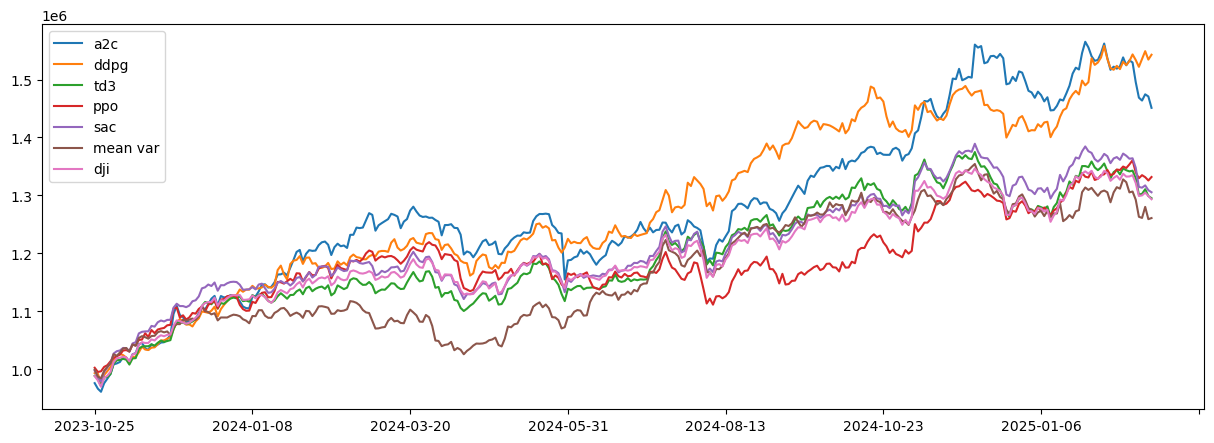

In [60]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
y_true = df_account_value_ddpg['account_value'].values
y_pred = df_account_value_ddpg['account_value'].shift(1).fillna(method="bfill").values
print("MSE:", mean_squared_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))

In [65]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Put your account value DataFrames in a dictionary
models = {
    "A2C": df_account_value_a2c,
    "DDPG": df_account_value_ddpg,
    "TD3": df_account_value_td3,
    "PPO": df_account_value_ppo,
    "SAC": df_account_value_sac
}

results = []

for name, df in models.items():
    y_true = df['account_value'].values
    # shift(1) for prediction, fillna for first row
    y_pred = df['account_value'].shift(1).bfill().values
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results.append([name, mse, r2])

# Convert results to DataFrame for better view
model_results = pd.DataFrame(results, columns=["Model", "MSE", "R^2"])
print(model_results)

  Model           MSE       R^2
0   A2C  1.517185e+08  0.993620
1  DDPG  1.116419e+08  0.995363
2   TD3  8.501785e+07  0.992010
3   PPO  7.907380e+07  0.989009
4   SAC  8.338083e+07  0.991494
